In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [ ]:
import shutil

# source (read-only) dataset
src = "/kaggle/input/chest-xray-pneumonia"

# destination (writable)
dst = "/content/chest-xray-pneumonia"

# copy recursively
shutil.copytree(src, dst, dirs_exist_ok=True)

print("Dataset copied to:", dst)


Dataset copied to: /content/chest-xray-pneumonia


In [ ]:
import os

base_dir = "/content/chest-xray-pneumonia/chest_xray/chest_xray"

# Loop through train, val, test
for split in ["train", "val", "test"]:
    print(f"\n📂 {split.upper()} SET:")
    split_path = os.path.join(base_dir, split)

    for category in ["NORMAL", "PNEUMONIA"]:
        category_path = os.path.join(split_path, category)
        count = len(os.listdir(category_path))
        print(f"   {category}: {count}")

    total = sum(len(os.listdir(os.path.join(split_path, c))) for c in ["NORMAL", "PNEUMONIA"])
    print(f"   Total: {total}")



📂 TRAIN SET:
   NORMAL: 1342
   PNEUMONIA: 3876
   Total: 5218

📂 VAL SET:
   NORMAL: 9
   PNEUMONIA: 9
   Total: 18

📂 TEST SET:
   NORMAL: 234
   PNEUMONIA: 390
   Total: 624


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder



# Augmentation for NORMAL (to oversample)
normal_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Light augmentation for PNEUMONIA
pneumonia_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


# Validation/Test (only resize + normalize)
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])









In [ ]:

class HybridDataset(ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)

        # Apply transform based on class
        if target == 0:   # NORMAL
            sample = normal_transform(sample)
        else:             # PNEUMONIA
            sample = pneumonia_transform(sample)

        return sample, target

In [ ]:

data_dir = "/content/chest-xray-pneumonia/chest_xray/chest_xray"

train_dataset = HybridDataset(root=f"{data_dir}/train", transform=None)
val_dataset   = ImageFolder(root=f"{data_dir}/val", transform=val_test_transform)
test_dataset  = ImageFolder(root=f"{data_dir}/test", transform=val_test_transform)


In [ ]:

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:

print(f"Train classes: {train_dataset.classes}")
print(f"Validation classes: {val_dataset.classes}")
print(f"Test classes: {test_dataset.classes}")

print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")


Train classes: ['NORMAL', 'PNEUMONIA']
Validation classes: ['NORMAL', 'PNEUMONIA']
Test classes: ['NORMAL', 'PNEUMONIA']
Train size: 5216
Val size: 16
Test size: 624


In [ ]:
len(train_loader),len(val_loader)

(163, 1)

In [ ]:
test_loader

In [ ]:
import torch
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Device: use GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get labels for training set
train_labels = [y for _, y in train_dataset.samples]

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels
)

# Convert to tensor on correct device
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print("Using device:", device)
print("Class Weights:", class_weights)


Using device: cuda
Class Weights: tensor([1.9448, 0.6730], device='cuda:0')


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ResNet18WithDropout(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet18WithDropout, self).__init__()
        # Load pretrained ResNet-18
        base_model = models.resnet18(pretrained=pretrained)

        # Freeze all layers
        for param in base_model.parameters():
            param.requires_grad = False

        # Keep layers
        self.conv1 = base_model.conv1
        self.bn1 = base_model.bn1
        self.relu = base_model.relu
        self.maxpool = base_model.maxpool

        self.layer1 = base_model.layer1
        self.layer2 = base_model.layer2
        self.layer3 = base_model.layer3
        self.layer4 = base_model.layer4

        # Add dropout after each big layer
        self.dropout1 = nn.Dropout(p=0.2)
        self.dropout2 = nn.Dropout(p=0.3)
        self.dropout3 = nn.Dropout(p=0.4)

        self.avgpool = base_model.avgpool
        num_features = base_model.fc.in_features

        # New classifier head
        self.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(256, 2)
        )

        # Unfreeze layer1–3 for fine-tuning
        for param in self.layer1.parameters():
            param.requires_grad = True
        for param in self.layer2.parameters():
            param.requires_grad = True
        for param in self.layer3.parameters():
            param.requires_grad = True

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.dropout1(x)

        x = self.layer2(x)
        x = self.dropout2(x)

        x = self.layer3(x)
        x = self.dropout3(x)

        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Instantiate
model = ResNet18WithDropout(pretrained=True).to(device)

# Print model summary
print(model)

# Count trainable params
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nNumber of trainable parameters: {trainable_params:,}")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 154MB/s]

ResNet18WithDropout(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inp

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), label_smoothing=0.1)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy

# Training function with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, patience=8):
    best_acc = 0.0
    patience_counter = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total

        val_loss, val_acc = evaluate(model, val_loader, criterion)

        # Save history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

        # Check for improvement
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
            torch.save(best_model_wts, "best_model.pt")
            torch.save(best_model_wts, "best_model.pth")
            print("Best model updated and saved.")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


# Evaluation with validation loss
def evaluate(model, loader, criterion):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    avg_loss = running_loss / len(loader)
    acc = 100 * correct / total
    return avg_loss, acc


# Function to print misclassified samples
def print_misclassifications(model, loader, classes):
    model.eval()
    misclassified = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            for i in range(len(labels)):
                if predicted[i] != labels[i]:
                    misclassified.append((predicted[i].item(), labels[i].item()))

    print("\nMisclassified Samples (Predicted -> Actual):")
    for pred, true in misclassified[:20]:  # Show first 20 only
        print(f"{classes[pred]} -> {classes[true]}")


In [ ]:
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20, patience=3)

# Print misclassifications
classes = ["Normal", "Pneumonia"]
print_misclassifications(model, val_loader, classes)


Epoch 1/20, Train Loss: 0.5076, Val Loss: 0.3254, Train Acc: 79.75%, Val Acc: 93.75%
Best model updated and saved.
Epoch 2/20, Train Loss: 0.3570, Val Loss: 0.3425, Train Acc: 94.13%, Val Acc: 93.75%
Epoch 3/20, Train Loss: 0.3367, Val Loss: 0.4573, Train Acc: 95.65%, Val Acc: 93.75%
Epoch 4/20, Train Loss: 0.3300, Val Loss: 0.3459, Train Acc: 95.99%, Val Acc: 100.00%
Best model updated and saved.
Epoch 5/20, Train Loss: 0.3190, Val Loss: 0.2339, Train Acc: 96.97%, Val Acc: 100.00%
Epoch 6/20, Train Loss: 0.3246, Val Loss: 0.4441, Train Acc: 96.57%, Val Acc: 93.75%
Epoch 7/20, Train Loss: 0.3154, Val Loss: 0.7009, Train Acc: 96.99%, Val Acc: 62.50%
Early stopping triggered!

Misclassified Samples (Predicted -> Actual):


In [17]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.grid(True)

    plt.show()




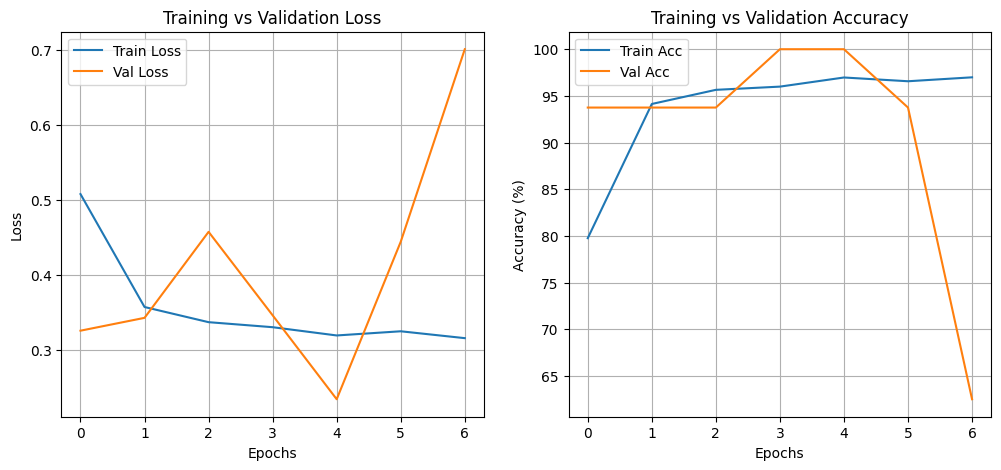

In [18]:
# ---- Call after training ----
plot_history(history)


📊 Classification Report:

              precision    recall  f1-score   support

      Normal       0.95      0.87      0.91       234
   Pneumonia       0.93      0.97      0.95       390

    accuracy                           0.94       624
   macro avg       0.94      0.92      0.93       624
weighted avg       0.94      0.94      0.94       624



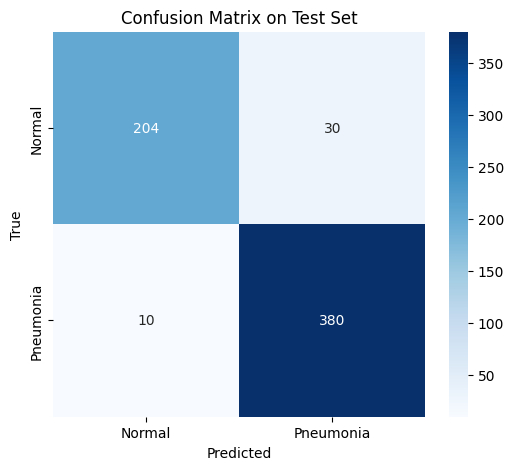

In [19]:
import torch
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Classes
classes = ["Normal", "Pneumonia"]

def predict_on_test(model, test_loader, device):
    model.eval()
    y_true, y_pred, y_probs = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Probabilities and predictions
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

    # Classification report
    print("\n📊 Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=classes))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix on Test Set")
    plt.show()

    return y_true, y_pred, y_probs

# ---- Run prediction ----
y_true, y_pred, y_probs = predict_on_test(model, test_loader, device)
